# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 uncertainty-adjusted topics most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 uncertainty-adjusted topics (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                      # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11825
EM converged at iteration 62, llf=-11635, convergence criterion=9.8708e-07 < tolerance=1e-06
EM start iterations, llf=-11838
EM converged at iteration 62, llf=-11647, convergence criterion=9.8592e-07 < tolerance=1e-06
EM start iterations, llf=-11894
EM converged at iteration 62, llf=-11701, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-11902
EM converged at iteration 62, llf=-11709, convergence criterion=9.8686e-07 < tolerance=1e-06
EM start iterations, llf=-11963
EM converged at iteration 62, llf=-11764, convergence criterion=9.9829e-07 < tolerance=1e-06
EM start iterations, llf=-11971
EM converged at iteration 62, llf=-11771, convergence criterion=9.9966e-07 < tolerance=1e-06
EM start iterations, llf=-12023
EM converged at iteration 62, llf=-11825, convergence criterion=9.9649e-07 < tolerance=1e-06
EM start iterations, llf=-12023
EM converged at iteration 62, llf=-11825, convergence criterion=9.9649e-07 < tolerance=1e-06


EM start iterations, llf=-13459
EM converged at iteration 33, llf=-13307, convergence criterion=9.5746e-07 < tolerance=1e-06
EM start iterations, llf=-13511
EM converged at iteration 32, llf=-13361, convergence criterion=9.6334e-07 < tolerance=1e-06
EM start iterations, llf=-13521
EM converged at iteration 32, llf=-13371, convergence criterion=9.8058e-07 < tolerance=1e-06
EM start iterations, llf=-13574
EM converged at iteration 32, llf=-13421, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-13574
EM converged at iteration 32, llf=-13421, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-13584
EM converged at iteration 32, llf=-13431, convergence criterion=9.7762e-07 < tolerance=1e-06
EM start iterations, llf=-13636
EM converged at iteration 32, llf=-13482, convergence criterion=9.6687e-07 < tolerance=1e-06
EM start iterations, llf=-13643
EM converged at iteration 33, llf=-13488, convergence criterion=9.5616e-07 < tolerance=1e-06


EM start iterations, llf=-15167
EM converged at iteration 33, llf=-15003, convergence criterion=9.9325e-07 < tolerance=1e-06
EM start iterations, llf=-15167
EM converged at iteration 33, llf=-15003, convergence criterion=9.9325e-07 < tolerance=1e-06
EM start iterations, llf=-15177
EM converged at iteration 33, llf=-15013, convergence criterion=9.8862e-07 < tolerance=1e-06
EM start iterations, llf=-15232
EM converged at iteration 33, llf=-15068, convergence criterion=9.8727e-07 < tolerance=1e-06
EM start iterations, llf=-15244
EM converged at iteration 33, llf=-15080, convergence criterion=9.9867e-07 < tolerance=1e-06
EM start iterations, llf=-15294
EM converged at iteration 33, llf=-15130, convergence criterion=9.9816e-07 < tolerance=1e-06
EM start iterations, llf=-15302
EM converged at iteration 34, llf=-15137, convergence criterion=9.4105e-07 < tolerance=1e-06
EM start iterations, llf=-15349
EM converged at iteration 34, llf=-15185, convergence criterion=9.4216e-07 < tolerance=1e-06


EM start iterations, llf=-16891
EM converged at iteration 28, llf=-16716, convergence criterion=9.4206e-07 < tolerance=1e-06
EM start iterations, llf=-16897
EM converged at iteration 28, llf=-16722, convergence criterion=9.589e-07 < tolerance=1e-06
EM start iterations, llf=-16948
EM converged at iteration 28, llf=-16772, convergence criterion=9.5853e-07 < tolerance=1e-06
EM start iterations, llf=-16956
EM converged at iteration 28, llf=-16780, convergence criterion=9.5956e-07 < tolerance=1e-06
EM start iterations, llf=-17013
EM converged at iteration 28, llf=-16837, convergence criterion=9.576e-07 < tolerance=1e-06
EM start iterations, llf=-17013
EM converged at iteration 28, llf=-16837, convergence criterion=9.576e-07 < tolerance=1e-06
EM start iterations, llf=-17021
EM converged at iteration 28, llf=-16844, convergence criterion=9.5171e-07 < tolerance=1e-06
EM start iterations, llf=-17072
EM converged at iteration 28, llf=-16894, convergence criterion=9.4411e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-18410
EM converged at iteration 30, llf=-18228, convergence criterion=9.4645e-07 < tolerance=1e-06
EM start iterations, llf=-18470
EM converged at iteration 30, llf=-18288, convergence criterion=9.4099e-07 < tolerance=1e-06
EM start iterations, llf=-18470
EM converged at iteration 30, llf=-18288, convergence criterion=9.4099e-07 < tolerance=1e-06
EM start iterations, llf=-18475
EM converged at iteration 30, llf=-18294, convergence criterion=9.4036e-07 < tolerance=1e-06
EM start iterations, llf=-18530
EM converged at iteration 30, llf=-18347, convergence criterion=9.4e-07 < tolerance=1e-06
EM start iterations, llf=-18537
EM converged at iteration 30, llf=-18355, convergence criterion=9.8177e-07 < tolerance=1e-06
EM start iterations, llf=-18591
EM converged at iteration 30, llf=-18408, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-18598
EM converged at iteration 30, llf=-18415, convergence criterion=9.7954e-07 < tolerance=1e-06
EM 

EM converged at iteration 52, llf=-12156, convergence criterion=9.8822e-07 < tolerance=1e-06
EM start iterations, llf=-12376
EM converged at iteration 51, llf=-12148, convergence criterion=9.9436e-07 < tolerance=1e-06
EM start iterations, llf=-12450
EM converged at iteration 51, llf=-12243, convergence criterion=9.9405e-07 < tolerance=1e-06
EM start iterations, llf=-12464
EM converged at iteration 55, llf=-12274, convergence criterion=9.9812e-07 < tolerance=1e-06
EM start iterations, llf=-12460
EM converged at iteration 43, llf=-12303, convergence criterion=9.9355e-07 < tolerance=1e-06
EM start iterations, llf=-12460
EM converged at iteration 44, llf=-12303, convergence criterion=9.9478e-07 < tolerance=1e-06
EM start iterations, llf=-12456
EM converged at iteration 44, llf=-12305, convergence criterion=9.8855e-07 < tolerance=1e-06
EM start iterations, llf=-12456
EM converged at iteration 44, llf=-12305, convergence criterion=9.8855e-07 < tolerance=1e-06
EM start iterations, llf=-12452


EM start iterations, llf=-13997
EM converged at iteration 37, llf=-13845, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-14035
EM converged at iteration 38, llf=-13883, convergence criterion=9.5014e-07 < tolerance=1e-06
EM start iterations, llf=-14037
EM converged at iteration 37, llf=-13884, convergence criterion=9.8052e-07 < tolerance=1e-06
EM start iterations, llf=-14079
EM converged at iteration 37, llf=-13925, convergence criterion=9.567e-07 < tolerance=1e-06
EM start iterations, llf=-14079
EM converged at iteration 37, llf=-13925, convergence criterion=9.567e-07 < tolerance=1e-06
EM start iterations, llf=-14090
EM converged at iteration 37, llf=-13935, convergence criterion=9.5807e-07 < tolerance=1e-06
EM start iterations, llf=-14144
EM converged at iteration 37, llf=-13990, convergence criterion=9.6547e-07 < tolerance=1e-06
EM start iterations, llf=-14152
EM converged at iteration 34, llf=-13998, convergence criterion=9.8429e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15725
EM converged at iteration 34, llf=-15556, convergence criterion=9.9654e-07 < tolerance=1e-06
EM start iterations, llf=-15725
EM converged at iteration 34, llf=-15556, convergence criterion=9.9654e-07 < tolerance=1e-06
EM start iterations, llf=-15734
EM converged at iteration 35, llf=-15566, convergence criterion=9.5003e-07 < tolerance=1e-06
EM start iterations, llf=-15789
EM converged at iteration 34, llf=-15621, convergence criterion=9.9375e-07 < tolerance=1e-06
EM start iterations, llf=-15794
EM converged at iteration 32, llf=-15625, convergence criterion=9.9402e-07 < tolerance=1e-06
EM start iterations, llf=-15848
EM converged at iteration 32, llf=-15678, convergence criterion=9.8385e-07 < tolerance=1e-06
EM start iterations, llf=-15853
EM converged at iteration 32, llf=-15684, convergence criterion=9.8571e-07 < tolerance=1e-06
EM start iterations, llf=-15898
EM converged at iteration 32, llf=-15728, convergence criterion=9.8719e-07 < tolerance=1e-06


EM start iterations, llf=-17435
EM converged at iteration 30, llf=-17255, convergence criterion=9.537e-07 < tolerance=1e-06
EM start iterations, llf=-17442
EM converged at iteration 30, llf=-17262, convergence criterion=9.5892e-07 < tolerance=1e-06
EM start iterations, llf=-17498
EM converged at iteration 30, llf=-17318, convergence criterion=9.6144e-07 < tolerance=1e-06
EM start iterations, llf=-17506
EM converged at iteration 30, llf=-17326, convergence criterion=9.6352e-07 < tolerance=1e-06
EM start iterations, llf=-17552
EM converged at iteration 30, llf=-17372, convergence criterion=9.623e-07 < tolerance=1e-06
EM start iterations, llf=-17552
EM converged at iteration 30, llf=-17372, convergence criterion=9.623e-07 < tolerance=1e-06
EM start iterations, llf=-17572
EM converged at iteration 30, llf=-17391, convergence criterion=9.6031e-07 < tolerance=1e-06
EM start iterations, llf=-17622
EM converged at iteration 30, llf=-17442, convergence criterion=9.5935e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-18961
EM converged at iteration 31, llf=-18774, convergence criterion=9.7043e-07 < tolerance=1e-06
EM start iterations, llf=-19010
EM converged at iteration 31, llf=-18822, convergence criterion=9.6998e-07 < tolerance=1e-06
EM start iterations, llf=-19010
EM converged at iteration 31, llf=-18822, convergence criterion=9.6998e-07 < tolerance=1e-06
EM start iterations, llf=-19017
EM converged at iteration 31, llf=-18830, convergence criterion=9.7107e-07 < tolerance=1e-06
EM start iterations, llf=-19072
EM converged at iteration 31, llf=-18884, convergence criterion=9.6775e-07 < tolerance=1e-06
EM start iterations, llf=-19082
EM converged at iteration 31, llf=-18894, convergence criterion=9.7766e-07 < tolerance=1e-06
EM start iterations, llf=-19134
EM converged at iteration 31, llf=-18946, convergence criterion=9.7736e-07 < tolerance=1e-06
EM start iterations, llf=-19143
EM converged at iteration 31, llf=-18955, convergence criterion=9.7857e-07 < tolerance=1e-06


EM converged at iteration 53, llf=-12642, convergence criterion=9.7267e-07 < tolerance=1e-06
EM start iterations, llf=-12794
EM converged at iteration 53, llf=-12648, convergence criterion=9.6914e-07 < tolerance=1e-06
EM start iterations, llf=-12849
EM converged at iteration 52, llf=-12703, convergence criterion=9.8128e-07 < tolerance=1e-06
EM start iterations, llf=-12857
EM converged at iteration 50, llf=-12711, convergence criterion=9.8438e-07 < tolerance=1e-06
EM start iterations, llf=-12908
EM converged at iteration 50, llf=-12762, convergence criterion=9.7425e-07 < tolerance=1e-06
EM start iterations, llf=-12919
EM converged at iteration 49, llf=-12773, convergence criterion=9.971e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 50, llf=-12829, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 50, llf=-12829, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-12982
E

EM start iterations, llf=-14502
EM converged at iteration 45, llf=-14343, convergence criterion=9.9429e-07 < tolerance=1e-06
EM start iterations, llf=-14552
EM converged at iteration 45, llf=-14393, convergence criterion=9.9133e-07 < tolerance=1e-06
EM start iterations, llf=-14562
EM converged at iteration 45, llf=-14403, convergence criterion=9.8716e-07 < tolerance=1e-06
EM start iterations, llf=-14615
EM converged at iteration 46, llf=-14456, convergence criterion=9.6563e-07 < tolerance=1e-06
EM start iterations, llf=-14615
EM converged at iteration 46, llf=-14456, convergence criterion=9.6563e-07 < tolerance=1e-06
EM start iterations, llf=-14624
EM converged at iteration 46, llf=-14465, convergence criterion=9.6472e-07 < tolerance=1e-06
EM start iterations, llf=-14678
EM converged at iteration 46, llf=-14519, convergence criterion=9.6847e-07 < tolerance=1e-06
EM start iterations, llf=-14689
EM converged at iteration 46, llf=-14531, convergence criterion=9.8098e-07 < tolerance=1e-06


EM start iterations, llf=-16275
EM converged at iteration 43, llf=-16104, convergence criterion=9.7534e-07 < tolerance=1e-06
EM start iterations, llf=-16275
EM converged at iteration 43, llf=-16104, convergence criterion=9.7534e-07 < tolerance=1e-06
EM start iterations, llf=-16284
EM converged at iteration 43, llf=-16114, convergence criterion=9.7562e-07 < tolerance=1e-06
EM start iterations, llf=-16336
EM converged at iteration 43, llf=-16166, convergence criterion=9.7175e-07 < tolerance=1e-06
EM start iterations, llf=-16346
EM converged at iteration 43, llf=-16176, convergence criterion=9.8275e-07 < tolerance=1e-06
EM start iterations, llf=-16397
EM converged at iteration 43, llf=-16226, convergence criterion=9.7837e-07 < tolerance=1e-06
EM start iterations, llf=-16405
EM converged at iteration 43, llf=-16235, convergence criterion=9.7927e-07 < tolerance=1e-06
EM start iterations, llf=-16457
EM converged at iteration 43, llf=-16286, convergence criterion=9.7667e-07 < tolerance=1e-06


EM start iterations, llf=-17994
EM converged at iteration 39, llf=-17815, convergence criterion=9.9577e-07 < tolerance=1e-06
EM start iterations, llf=-18000
EM converged at iteration 40, llf=-17821, convergence criterion=9.7579e-07 < tolerance=1e-06
EM start iterations, llf=-18046
EM converged at iteration 40, llf=-17866, convergence criterion=9.8179e-07 < tolerance=1e-06
EM start iterations, llf=-18054
EM converged at iteration 40, llf=-17873, convergence criterion=9.794e-07 < tolerance=1e-06
EM start iterations, llf=-18105
EM converged at iteration 40, llf=-17925, convergence criterion=9.6952e-07 < tolerance=1e-06
EM start iterations, llf=-18105
EM converged at iteration 40, llf=-17925, convergence criterion=9.6952e-07 < tolerance=1e-06
EM start iterations, llf=-18111
EM converged at iteration 40, llf=-17931, convergence criterion=9.7304e-07 < tolerance=1e-06
EM start iterations, llf=-18163
EM converged at iteration 40, llf=-17982, convergence criterion=9.742e-07 < tolerance=1e-06
EM

EM start iterations, llf=-19233
EM converged at iteration 38, llf=-19050, convergence criterion=9.9634e-07 < tolerance=1e-06
EM start iterations, llf=-19286
EM converged at iteration 38, llf=-19102, convergence criterion=9.9689e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 1:23:45.358993.
EM start iterations, llf=-11329
EM converged at iteration 55, llf=-11199, convergence criterion=9.9954e-07 < tolerance=1e-06
EM start iterations, llf=-11341
EM converged at iteration 55, llf=-11211, convergence criterion=9.8819e-07 < tolerance=1e-06
EM start iterations, llf=-11397
EM converged at iteration 55, llf=-11266, convergence criterion=9.931e-07 < tolerance=1e-06
EM start iterations, llf=-11405
EM converged at iteration 55, llf=-11274, convergence criterion=9.9497e-07 < tolerance=1e-06
EM start iterations, llf=-11458
EM converged at iteration 54, llf=-11329, convergence criterion=9.7976e-07 < tolerance=1e-06
EM start iterations, llf=-11468
EM converged at itera

EM converged at iteration 35, llf=-12602, convergence criterion=9.9041e-07 < tolerance=1e-06
EM start iterations, llf=-12750
EM converged at iteration 35, llf=-12613, convergence criterion=9.9189e-07 < tolerance=1e-06
EM start iterations, llf=-12777
EM converged at iteration 34, llf=-12643, convergence criterion=9.6926e-07 < tolerance=1e-06
EM start iterations, llf=-12782
EM converged at iteration 33, llf=-12647, convergence criterion=9.8651e-07 < tolerance=1e-06
EM start iterations, llf=-12846
EM converged at iteration 32, llf=-12709, convergence criterion=9.4104e-07 < tolerance=1e-06
EM start iterations, llf=-12846
EM converged at iteration 32, llf=-12711, convergence criterion=9.8309e-07 < tolerance=1e-06
EM start iterations, llf=-12885
EM converged at iteration 31, llf=-12751, convergence criterion=9.9746e-07 < tolerance=1e-06
EM start iterations, llf=-12885
EM converged at iteration 31, llf=-12751, convergence criterion=9.9746e-07 < tolerance=1e-06
EM start iterations, llf=-12891


EM start iterations, llf=-14301
EM converged at iteration 31, llf=-14164, convergence criterion=9.4396e-07 < tolerance=1e-06
EM start iterations, llf=-14349
EM converged at iteration 31, llf=-14213, convergence criterion=9.3597e-07 < tolerance=1e-06
EM start iterations, llf=-14357
EM converged at iteration 31, llf=-14221, convergence criterion=9.3471e-07 < tolerance=1e-06
EM start iterations, llf=-14410
EM converged at iteration 30, llf=-14275, convergence criterion=9.8281e-07 < tolerance=1e-06
EM start iterations, llf=-14410
EM converged at iteration 30, llf=-14275, convergence criterion=9.8281e-07 < tolerance=1e-06
EM start iterations, llf=-14419
EM converged at iteration 30, llf=-14284, convergence criterion=9.7395e-07 < tolerance=1e-06
EM start iterations, llf=-14473
EM converged at iteration 30, llf=-14337, convergence criterion=9.7529e-07 < tolerance=1e-06
EM start iterations, llf=-14482
EM converged at iteration 30, llf=-14347, convergence criterion=9.7997e-07 < tolerance=1e-06


EM start iterations, llf=-15988
EM converged at iteration 25, llf=-15846, convergence criterion=9.2868e-07 < tolerance=1e-06
EM start iterations, llf=-15988
EM converged at iteration 25, llf=-15846, convergence criterion=9.2868e-07 < tolerance=1e-06
EM start iterations, llf=-16002
EM converged at iteration 25, llf=-15859, convergence criterion=9.3283e-07 < tolerance=1e-06
EM start iterations, llf=-16064
EM converged at iteration 25, llf=-15921, convergence criterion=9.3404e-07 < tolerance=1e-06
EM start iterations, llf=-16067
EM converged at iteration 25, llf=-15925, convergence criterion=9.2887e-07 < tolerance=1e-06
EM start iterations, llf=-16117
EM converged at iteration 24, llf=-15975, convergence criterion=9.8877e-07 < tolerance=1e-06
EM start iterations, llf=-16123
EM converged at iteration 24, llf=-15982, convergence criterion=9.9412e-07 < tolerance=1e-06
EM start iterations, llf=-16177
EM converged at iteration 24, llf=-16036, convergence criterion=9.9275e-07 < tolerance=1e-06


EM start iterations, llf=-17435
EM converged at iteration 25, llf=-17296, convergence criterion=9.8569e-07 < tolerance=1e-06
EM start iterations, llf=-17453
EM converged at iteration 25, llf=-17311, convergence criterion=9.9814e-07 < tolerance=1e-06
EM start iterations, llf=-17510
EM converged at iteration 25, llf=-17368, convergence criterion=9.9441e-07 < tolerance=1e-06
EM start iterations, llf=-17514
EM converged at iteration 25, llf=-17372, convergence criterion=9.8934e-07 < tolerance=1e-06
EM start iterations, llf=-17571
EM converged at iteration 25, llf=-17429, convergence criterion=9.7559e-07 < tolerance=1e-06
EM start iterations, llf=-17571
EM converged at iteration 25, llf=-17429, convergence criterion=9.7559e-07 < tolerance=1e-06
EM start iterations, llf=-17577
EM converged at iteration 25, llf=-17434, convergence criterion=9.754e-07 < tolerance=1e-06
EM start iterations, llf=-17628
EM converged at iteration 25, llf=-17485, convergence criterion=9.7223e-07 < tolerance=1e-06
E

EM converged at iteration 40, llf=-11664, convergence criterion=9.5007e-07 < tolerance=1e-06
EM start iterations, llf=-11803
EM converged at iteration 40, llf=-11668, convergence criterion=9.5213e-07 < tolerance=1e-06
EM start iterations, llf=-11854
EM converged at iteration 38, llf=-11727, convergence criterion=9.817e-07 < tolerance=1e-06
EM start iterations, llf=-11854
EM converged at iteration 38, llf=-11727, convergence criterion=9.817e-07 < tolerance=1e-06
EM start iterations, llf=-11876
EM converged at iteration 40, llf=-11744, convergence criterion=9.7954e-07 < tolerance=1e-06
EM start iterations, llf=-11947
EM converged at iteration 42, llf=-11817, convergence criterion=9.9895e-07 < tolerance=1e-06
EM start iterations, llf=-11927
EM converged at iteration 45, llf=-11800, convergence criterion=9.8828e-07 < tolerance=1e-06
EM start iterations, llf=-11868
EM converged at iteration 51, llf=-11725, convergence criterion=9.8386e-07 < tolerance=1e-06
EM start iterations, llf=-11867
EM

EM start iterations, llf=-13225
EM converged at iteration 37, llf=-13083, convergence criterion=9.5942e-07 < tolerance=1e-06
EM start iterations, llf=-13232
EM converged at iteration 36, llf=-13093, convergence criterion=9.8935e-07 < tolerance=1e-06
EM start iterations, llf=-13276
EM converged at iteration 36, llf=-13137, convergence criterion=9.9692e-07 < tolerance=1e-06
EM start iterations, llf=-13285
EM converged at iteration 37, llf=-13147, convergence criterion=9.9071e-07 < tolerance=1e-06
EM start iterations, llf=-13319
EM converged at iteration 37, llf=-13181, convergence criterion=9.7317e-07 < tolerance=1e-06
EM start iterations, llf=-13318
EM converged at iteration 38, llf=-13181, convergence criterion=9.7558e-07 < tolerance=1e-06
EM start iterations, llf=-13362
EM converged at iteration 38, llf=-13223, convergence criterion=9.6013e-07 < tolerance=1e-06
EM start iterations, llf=-13362
EM converged at iteration 38, llf=-13223, convergence criterion=9.6013e-07 < tolerance=1e-06


EM start iterations, llf=-14835
EM converged at iteration 30, llf=-14700, convergence criterion=9.9853e-07 < tolerance=1e-06
EM start iterations, llf=-14888
EM converged at iteration 31, llf=-14752, convergence criterion=9.6419e-07 < tolerance=1e-06
EM start iterations, llf=-14895
EM converged at iteration 31, llf=-14759, convergence criterion=9.6722e-07 < tolerance=1e-06
EM start iterations, llf=-14939
EM converged at iteration 31, llf=-14803, convergence criterion=9.5688e-07 < tolerance=1e-06
EM start iterations, llf=-14939
EM converged at iteration 31, llf=-14803, convergence criterion=9.5688e-07 < tolerance=1e-06
EM start iterations, llf=-14953
EM converged at iteration 31, llf=-14816, convergence criterion=9.6613e-07 < tolerance=1e-06
EM start iterations, llf=-15007
EM converged at iteration 30, llf=-14870, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-15011
EM converged at iteration 29, llf=-14874, convergence criterion=9.9263e-07 < tolerance=1e-06


EM start iterations, llf=-16515
EM converged at iteration 27, llf=-16373, convergence criterion=9.781e-07 < tolerance=1e-06
EM start iterations, llf=-16515
EM converged at iteration 27, llf=-16373, convergence criterion=9.781e-07 < tolerance=1e-06
EM start iterations, llf=-16524
EM converged at iteration 27, llf=-16381, convergence criterion=9.481e-07 < tolerance=1e-06
EM start iterations, llf=-16573
EM converged at iteration 27, llf=-16430, convergence criterion=9.3323e-07 < tolerance=1e-06
EM start iterations, llf=-16579
EM converged at iteration 27, llf=-16436, convergence criterion=9.391e-07 < tolerance=1e-06
EM start iterations, llf=-16633
EM converged at iteration 27, llf=-16491, convergence criterion=9.4316e-07 < tolerance=1e-06
EM start iterations, llf=-16642
EM converged at iteration 27, llf=-16501, convergence criterion=9.354e-07 < tolerance=1e-06
EM start iterations, llf=-16685
EM converged at iteration 27, llf=-16543, convergence criterion=9.4014e-07 < tolerance=1e-06
EM st

EM start iterations, llf=-17973
EM converged at iteration 27, llf=-17828, convergence criterion=9.4302e-07 < tolerance=1e-06
EM start iterations, llf=-17981
EM converged at iteration 27, llf=-17836, convergence criterion=9.4205e-07 < tolerance=1e-06
EM start iterations, llf=-18032
EM converged at iteration 27, llf=-17886, convergence criterion=9.4373e-07 < tolerance=1e-06
EM start iterations, llf=-18039
EM converged at iteration 27, llf=-17893, convergence criterion=9.4037e-07 < tolerance=1e-06
EM start iterations, llf=-18084
EM converged at iteration 27, llf=-17939, convergence criterion=9.3912e-07 < tolerance=1e-06
EM start iterations, llf=-18084
EM converged at iteration 27, llf=-17939, convergence criterion=9.3912e-07 < tolerance=1e-06
EM start iterations, llf=-18089
EM converged at iteration 27, llf=-17944, convergence criterion=9.2776e-07 < tolerance=1e-06
EM start iterations, llf=-18143
EM converged at iteration 26, llf=-17998, convergence criterion=9.8549e-07 < tolerance=1e-06


EM start iterations, llf=-12110
EM converged at iteration 66, llf=-11968, convergence criterion=9.9773e-07 < tolerance=1e-06
EM start iterations, llf=-12124
EM converged at iteration 67, llf=-11981, convergence criterion=9.7522e-07 < tolerance=1e-06
EM start iterations, llf=-12169
EM converged at iteration 64, llf=-12026, convergence criterion=9.9145e-07 < tolerance=1e-06
EM start iterations, llf=-12169
EM converged at iteration 64, llf=-12026, convergence criterion=9.9145e-07 < tolerance=1e-06
EM start iterations, llf=-12173
EM converged at iteration 64, llf=-12031, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-12220
EM converged at iteration 65, llf=-12079, convergence criterion=9.9407e-07 < tolerance=1e-06
EM start iterations, llf=-12235
EM converged at iteration 64, llf=-12093, convergence criterion=9.9238e-07 < tolerance=1e-06
EM start iterations, llf=-12287
EM converged at iteration 64, llf=-12145, convergence criterion=9.9791e-07 < tolerance=1e-06


EM start iterations, llf=-13700
EM converged at iteration 57, llf=-13560, convergence criterion=9.7617e-07 < tolerance=1e-06
EM start iterations, llf=-13706
EM converged at iteration 57, llf=-13566, convergence criterion=9.9846e-07 < tolerance=1e-06
EM start iterations, llf=-13758
EM converged at iteration 57, llf=-13618, convergence criterion=9.8572e-07 < tolerance=1e-06
EM start iterations, llf=-13764
EM converged at iteration 57, llf=-13625, convergence criterion=9.9397e-07 < tolerance=1e-06
EM start iterations, llf=-13817
EM converged at iteration 57, llf=-13674, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-13822
EM converged at iteration 56, llf=-13684, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-13879
EM converged at iteration 52, llf=-13740, convergence criterion=9.8568e-07 < tolerance=1e-06
EM start iterations, llf=-13879
EM converged at iteration 52, llf=-13740, convergence criterion=9.8568e-07 < tolerance=1e-06


EM start iterations, llf=-15356
EM converged at iteration 48, llf=-15215, convergence criterion=9.8299e-07 < tolerance=1e-06
EM start iterations, llf=-15406
EM converged at iteration 48, llf=-15264, convergence criterion=9.9828e-07 < tolerance=1e-06
EM start iterations, llf=-15412
EM converged at iteration 49, llf=-15269, convergence criterion=9.8216e-07 < tolerance=1e-06
EM start iterations, llf=-15469
EM converged at iteration 49, llf=-15327, convergence criterion=9.9744e-07 < tolerance=1e-06
EM start iterations, llf=-15469
EM converged at iteration 49, llf=-15327, convergence criterion=9.9744e-07 < tolerance=1e-06
EM start iterations, llf=-15480
EM converged at iteration 49, llf=-15337, convergence criterion=9.8698e-07 < tolerance=1e-06
EM start iterations, llf=-15529
EM converged at iteration 49, llf=-15387, convergence criterion=9.7592e-07 < tolerance=1e-06
EM start iterations, llf=-15539
EM converged at iteration 49, llf=-15397, convergence criterion=9.7742e-07 < tolerance=1e-06


EM start iterations, llf=-17046
EM converged at iteration 47, llf=-16902, convergence criterion=9.7232e-07 < tolerance=1e-06
EM start iterations, llf=-17046
EM converged at iteration 47, llf=-16902, convergence criterion=9.7232e-07 < tolerance=1e-06
EM start iterations, llf=-17052
EM converged at iteration 47, llf=-16909, convergence criterion=9.7871e-07 < tolerance=1e-06
EM start iterations, llf=-17113
EM converged at iteration 46, llf=-16971, convergence criterion=9.7879e-07 < tolerance=1e-06
EM start iterations, llf=-17119
EM converged at iteration 45, llf=-16978, convergence criterion=9.9765e-07 < tolerance=1e-06
EM start iterations, llf=-17160
EM converged at iteration 46, llf=-17018, convergence criterion=9.9737e-07 < tolerance=1e-06
EM start iterations, llf=-17171
EM converged at iteration 48, llf=-17027, convergence criterion=9.7679e-07 < tolerance=1e-06
EM start iterations, llf=-17224
EM converged at iteration 48, llf=-17079, convergence criterion=9.7028e-07 < tolerance=1e-06


EM start iterations, llf=-18228
EM converged at iteration 42, llf=-18084, convergence criterion=9.7662e-07 < tolerance=1e-06
EM start iterations, llf=-18239
EM converged at iteration 42, llf=-18096, convergence criterion=9.7157e-07 < tolerance=1e-06
EM start iterations, llf=-18293
EM converged at iteration 42, llf=-18149, convergence criterion=9.8498e-07 < tolerance=1e-06
EM start iterations, llf=-18297
EM converged at iteration 42, llf=-18153, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-18347
EM converged at iteration 42, llf=-18204, convergence criterion=9.6897e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 3 estimated in 1:50:45.365388.
EM start iterations, llf=-11135
EM converged at iteration 53, llf=-11007, convergence criterion=9.8495e-07 < tolerance=1e-06
EM start iterations, llf=-11154
EM converged at iteration 53, llf=-11024, convergence criterion=9.9574e-07 < tolerance=1e-06
EM start iterations, llf=-11205
EM converged at iter

EM start iterations, llf=-12368
EM converged at iteration 39, llf=-12234, convergence criterion=9.845e-07 < tolerance=1e-06
EM start iterations, llf=-12409
EM converged at iteration 40, llf=-12277, convergence criterion=9.5861e-07 < tolerance=1e-06
EM start iterations, llf=-12459
EM converged at iteration 39, llf=-12323, convergence criterion=9.9669e-07 < tolerance=1e-06
EM start iterations, llf=-12497
EM converged at iteration 40, llf=-12361, convergence criterion=9.727e-07 < tolerance=1e-06
EM start iterations, llf=-12497
EM converged at iteration 40, llf=-12361, convergence criterion=9.727e-07 < tolerance=1e-06
EM start iterations, llf=-12509
EM converged at iteration 40, llf=-12373, convergence criterion=9.7701e-07 < tolerance=1e-06
EM start iterations, llf=-12554
EM converged at iteration 39, llf=-12410, convergence criterion=9.7012e-07 < tolerance=1e-06
EM start iterations, llf=-12556
EM converged at iteration 38, llf=-12411, convergence criterion=9.7615e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-13968
EM converged at iteration 41, llf=-13820, convergence criterion=9.6773e-07 < tolerance=1e-06
EM start iterations, llf=-13968
EM converged at iteration 41, llf=-13820, convergence criterion=9.6773e-07 < tolerance=1e-06
EM start iterations, llf=-13970
EM converged at iteration 41, llf=-13826, convergence criterion=9.5502e-07 < tolerance=1e-06
EM start iterations, llf=-14017
EM converged at iteration 40, llf=-13871, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-14027
EM converged at iteration 40, llf=-13881, convergence criterion=9.9806e-07 < tolerance=1e-06
EM start iterations, llf=-14084
EM converged at iteration 41, llf=-13935, convergence criterion=9.6053e-07 < tolerance=1e-06
EM start iterations, llf=-14089
EM converged at iteration 41, llf=-13943, convergence criterion=9.5049e-07 < tolerance=1e-06
EM start iterations, llf=-14148
EM converged at iteration 40, llf=-13999, convergence criterion=9.8287e-07 < tolerance=1e-06


EM start iterations, llf=-15605
EM converged at iteration 35, llf=-15444, convergence criterion=9.7529e-07 < tolerance=1e-06
EM start iterations, llf=-15608
EM converged at iteration 35, llf=-15451, convergence criterion=9.6109e-07 < tolerance=1e-06
EM start iterations, llf=-15658
EM converged at iteration 35, llf=-15501, convergence criterion=9.6996e-07 < tolerance=1e-06
EM start iterations, llf=-15665
EM converged at iteration 35, llf=-15508, convergence criterion=9.6423e-07 < tolerance=1e-06
EM start iterations, llf=-15711
EM converged at iteration 35, llf=-15552, convergence criterion=9.7774e-07 < tolerance=1e-06
EM start iterations, llf=-15711
EM converged at iteration 35, llf=-15552, convergence criterion=9.7774e-07 < tolerance=1e-06
EM start iterations, llf=-15723
EM converged at iteration 35, llf=-15565, convergence criterion=9.6555e-07 < tolerance=1e-06
EM start iterations, llf=-15792
EM converged at iteration 35, llf=-15627, convergence criterion=9.7284e-07 < tolerance=1e-06


EM start iterations, llf=-17260
EM converged at iteration 36, llf=-17088, convergence criterion=9.4867e-07 < tolerance=1e-06
EM start iterations, llf=-17108
EM converged at iteration 36, llf=-16944, convergence criterion=9.7549e-07 < tolerance=1e-06
EM start iterations, llf=-17108
EM converged at iteration 36, llf=-16944, convergence criterion=9.7549e-07 < tolerance=1e-06
EM start iterations, llf=-17114
EM converged at iteration 36, llf=-16949, convergence criterion=9.8388e-07 < tolerance=1e-06
EM start iterations, llf=-17162
EM converged at iteration 36, llf=-16993, convergence criterion=9.9612e-07 < tolerance=1e-06
EM start iterations, llf=-17181
EM converged at iteration 36, llf=-17010, convergence criterion=9.8701e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM converged at iteration 36, llf=-17068, convergence criterion=9.9093e-07 < tolerance=1e-06
EM start iterations, llf=-17246
EM converged at iteration 36, llf=-17073, convergence criterion=9.8389e-07 < tolerance=1e-06


EM start iterations, llf=-11497
EM converged at iteration 59, llf=-11353, convergence criterion=9.8419e-07 < tolerance=1e-06
EM start iterations, llf=-11508
EM converged at iteration 60, llf=-11365, convergence criterion=9.7718e-07 < tolerance=1e-06
EM start iterations, llf=-11532
EM converged at iteration 54, llf=-11396, convergence criterion=9.7388e-07 < tolerance=1e-06
EM start iterations, llf=-11536
EM converged at iteration 41, llf=-11402, convergence criterion=9.698e-07 < tolerance=1e-06
EM start iterations, llf=-11562
EM converged at iteration 41, llf=-11430, convergence criterion=9.5001e-07 < tolerance=1e-06
EM start iterations, llf=-11570
EM converged at iteration 42, llf=-11436, convergence criterion=9.6726e-07 < tolerance=1e-06
EM start iterations, llf=-11662
EM converged at iteration 46, llf=-11525, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-11662
EM converged at iteration 46, llf=-11525, convergence criterion=9.8684e-07 < tolerance=1e-06
E

EM start iterations, llf=-12857
EM converged at iteration 47, llf=-12715, convergence criterion=9.8687e-07 < tolerance=1e-06
EM start iterations, llf=-12870
EM converged at iteration 49, llf=-12727, convergence criterion=9.8242e-07 < tolerance=1e-06
EM start iterations, llf=-12907
EM converged at iteration 49, llf=-12765, convergence criterion=9.9084e-07 < tolerance=1e-06
EM start iterations, llf=-12920
EM converged at iteration 46, llf=-12776, convergence criterion=9.8473e-07 < tolerance=1e-06
EM start iterations, llf=-12955
EM converged at iteration 49, llf=-12812, convergence criterion=9.8029e-07 < tolerance=1e-06
EM start iterations, llf=-12955
EM converged at iteration 49, llf=-12812, convergence criterion=9.8029e-07 < tolerance=1e-06
EM start iterations, llf=-12965
EM converged at iteration 45, llf=-12824, convergence criterion=9.6764e-07 < tolerance=1e-06
EM start iterations, llf=-13007
EM converged at iteration 39, llf=-12867, convergence criterion=9.8848e-07 < tolerance=1e-06


EM start iterations, llf=-14436
EM converged at iteration 73, llf=-14290, convergence criterion=9.8944e-07 < tolerance=1e-06
EM start iterations, llf=-14486
EM converged at iteration 71, llf=-14340, convergence criterion=9.947e-07 < tolerance=1e-06
EM start iterations, llf=-14486
EM converged at iteration 71, llf=-14340, convergence criterion=9.947e-07 < tolerance=1e-06
EM start iterations, llf=-14502
EM converged at iteration 69, llf=-14354, convergence criterion=9.9751e-07 < tolerance=1e-06
EM start iterations, llf=-14547
EM converged at iteration 69, llf=-14400, convergence criterion=9.8643e-07 < tolerance=1e-06
EM start iterations, llf=-14558
EM converged at iteration 69, llf=-14411, convergence criterion=9.9128e-07 < tolerance=1e-06
EM start iterations, llf=-14599
EM converged at iteration 69, llf=-14457, convergence criterion=9.9316e-07 < tolerance=1e-06
EM start iterations, llf=-14605
EM converged at iteration 68, llf=-14463, convergence criterion=9.9882e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16078
EM converged at iteration 57, llf=-15911, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-16129
EM converged at iteration 57, llf=-15959, convergence criterion=9.8723e-07 < tolerance=1e-06
EM start iterations, llf=-16132
EM converged at iteration 58, llf=-15964, convergence criterion=9.9755e-07 < tolerance=1e-06
EM start iterations, llf=-16183
EM converged at iteration 59, llf=-16014, convergence criterion=9.9362e-07 < tolerance=1e-06
EM start iterations, llf=-16192
EM converged at iteration 58, llf=-16022, convergence criterion=9.9635e-07 < tolerance=1e-06
EM start iterations, llf=-16245
EM converged at iteration 57, llf=-16075, convergence criterion=9.7817e-07 < tolerance=1e-06
EM start iterations, llf=-16245
EM converged at iteration 57, llf=-16075, convergence criterion=9.7817e-07 < tolerance=1e-06
EM start iterations, llf=-16251
EM converged at iteration 58, llf=-16082, convergence criterion=9.8986e-07 < tolerance=1e-06


EM start iterations, llf=-17585
EM converged at iteration 54, llf=-17414, convergence criterion=9.8262e-07 < tolerance=1e-06
EM start iterations, llf=-17597
EM converged at iteration 54, llf=-17426, convergence criterion=9.7692e-07 < tolerance=1e-06
EM start iterations, llf=-17643
EM converged at iteration 54, llf=-17471, convergence criterion=9.9553e-07 < tolerance=1e-06
EM start iterations, llf=-17643
EM converged at iteration 54, llf=-17471, convergence criterion=9.9553e-07 < tolerance=1e-06
EM start iterations, llf=-17652
EM converged at iteration 54, llf=-17480, convergence criterion=9.9473e-07 < tolerance=1e-06
EM start iterations, llf=-17697
EM converged at iteration 54, llf=-17527, convergence criterion=9.9242e-07 < tolerance=1e-06
EM start iterations, llf=-17704
EM converged at iteration 54, llf=-17534, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-17751
EM converged at iteration 54, llf=-17580, convergence criterion=9.8641e-07 < tolerance=1e-06


EM start iterations, llf=-11690
EM converged at iteration 80, llf=-11567, convergence criterion=9.897e-07 < tolerance=1e-06
EM start iterations, llf=-11631
EM iteration 100, llf=-11178, convergence criterion=1.6316e-06
EM converged at iteration 132, llf=-11178, convergence criterion=9.9982e-07 < tolerance=1e-06
EM start iterations, llf=-11631
EM iteration 100, llf=-11178, convergence criterion=1.6316e-06
EM converged at iteration 132, llf=-11178, convergence criterion=9.9982e-07 < tolerance=1e-06
EM start iterations, llf=-11639
EM iteration 100, llf=-11197, convergence criterion=1.0344e-06
EM converged at iteration 103, llf=-11197, convergence criterion=9.8366e-07 < tolerance=1e-06
EM start iterations, llf=-11773
EM converged at iteration 80, llf=-11647, convergence criterion=9.8301e-07 < tolerance=1e-06
EM start iterations, llf=-11780
EM converged at iteration 66, llf=-11655, convergence criterion=9.8355e-07 < tolerance=1e-06
EM start iterations, llf=-11826
EM converged at iteration 6

EM converged at iteration 67, llf=-13109, convergence criterion=9.9876e-07 < tolerance=1e-06
EM start iterations, llf=-13263
EM converged at iteration 67, llf=-13109, convergence criterion=9.9876e-07 < tolerance=1e-06
EM start iterations, llf=-13273
EM converged at iteration 68, llf=-13120, convergence criterion=9.8543e-07 < tolerance=1e-06
EM start iterations, llf=-13322
EM converged at iteration 66, llf=-13166, convergence criterion=9.8001e-07 < tolerance=1e-06
EM start iterations, llf=-13331
EM converged at iteration 65, llf=-13176, convergence criterion=9.884e-07 < tolerance=1e-06
EM start iterations, llf=-13354
EM converged at iteration 76, llf=-13205, convergence criterion=9.7956e-07 < tolerance=1e-06
EM start iterations, llf=-13351
EM converged at iteration 80, llf=-13206, convergence criterion=9.769e-07 < tolerance=1e-06
EM start iterations, llf=-13390
EM converged at iteration 79, llf=-13244, convergence criterion=9.9346e-07 < tolerance=1e-06
EM start iterations, llf=-13390
EM

EM start iterations, llf=-14500
EM converged at iteration 79, llf=-14348, convergence criterion=9.9637e-07 < tolerance=1e-06
EM start iterations, llf=-14506
EM converged at iteration 80, llf=-14355, convergence criterion=9.7955e-07 < tolerance=1e-06
EM start iterations, llf=-14941
EM converged at iteration 73, llf=-14786, convergence criterion=9.9051e-07 < tolerance=1e-06
EM start iterations, llf=-14946
EM converged at iteration 73, llf=-14790, convergence criterion=9.9005e-07 < tolerance=1e-06
EM start iterations, llf=-14991
EM converged at iteration 72, llf=-14835, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-14991
EM converged at iteration 72, llf=-14835, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-15003
EM converged at iteration 72, llf=-14847, convergence criterion=9.9439e-07 < tolerance=1e-06
EM start iterations, llf=-15056
EM converged at iteration 73, llf=-14897, convergence criterion=9.8523e-07 < tolerance=1e-06


EM start iterations, llf=-16520
EM converged at iteration 69, llf=-16350, convergence criterion=9.9971e-07 < tolerance=1e-06
EM start iterations, llf=-16576
EM converged at iteration 69, llf=-16405, convergence criterion=9.9992e-07 < tolerance=1e-06
EM start iterations, llf=-16576
EM converged at iteration 69, llf=-16405, convergence criterion=9.9992e-07 < tolerance=1e-06
EM start iterations, llf=-16591
EM converged at iteration 69, llf=-16416, convergence criterion=9.8524e-07 < tolerance=1e-06
EM start iterations, llf=-16633
EM converged at iteration 69, llf=-16460, convergence criterion=9.9941e-07 < tolerance=1e-06
EM start iterations, llf=-16645
EM converged at iteration 69, llf=-16470, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-16701
EM converged at iteration 68, llf=-16525, convergence criterion=9.9421e-07 < tolerance=1e-06
EM start iterations, llf=-16706
EM converged at iteration 69, llf=-16531, convergence criterion=9.8741e-07 < tolerance=1e-06
E

EM start iterations, llf=-17967
EM converged at iteration 64, llf=-17788, convergence criterion=9.9266e-07 < tolerance=1e-06
EM start iterations, llf=-18021
EM converged at iteration 64, llf=-17842, convergence criterion=9.9694e-07 < tolerance=1e-06
EM start iterations, llf=-18035
EM converged at iteration 64, llf=-17853, convergence criterion=9.8554e-07 < tolerance=1e-06
EM start iterations, llf=-18089
EM converged at iteration 64, llf=-17907, convergence criterion=9.7698e-07 < tolerance=1e-06
EM start iterations, llf=-18094
EM converged at iteration 64, llf=-17912, convergence criterion=9.7446e-07 < tolerance=1e-06
EM start iterations, llf=-18139
EM converged at iteration 64, llf=-17955, convergence criterion=9.7407e-07 < tolerance=1e-06
EM start iterations, llf=-18139
EM converged at iteration 64, llf=-17955, convergence criterion=9.7407e-07 < tolerance=1e-06
EM start iterations, llf=-17897
EM converged at iteration 59, llf=-17705, convergence criterion=9.7995e-07 < tolerance=1e-06


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


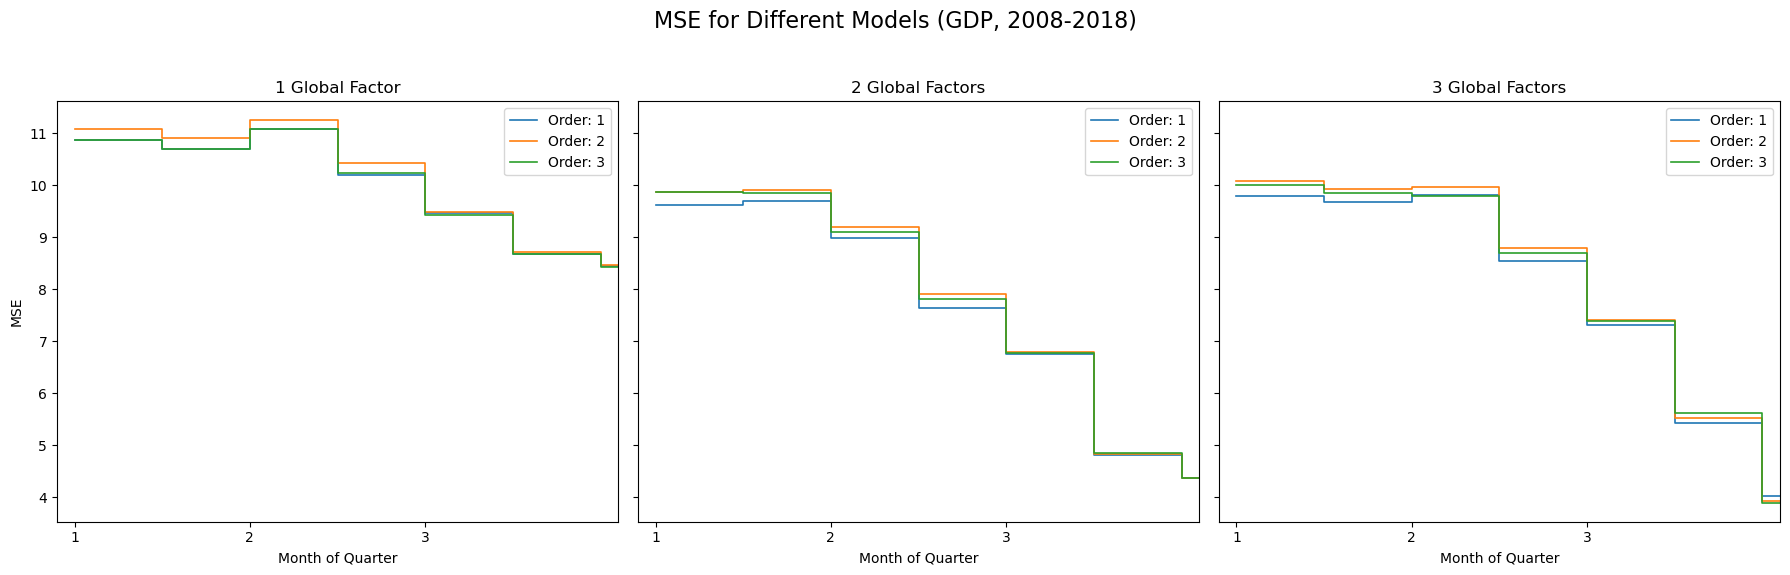

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


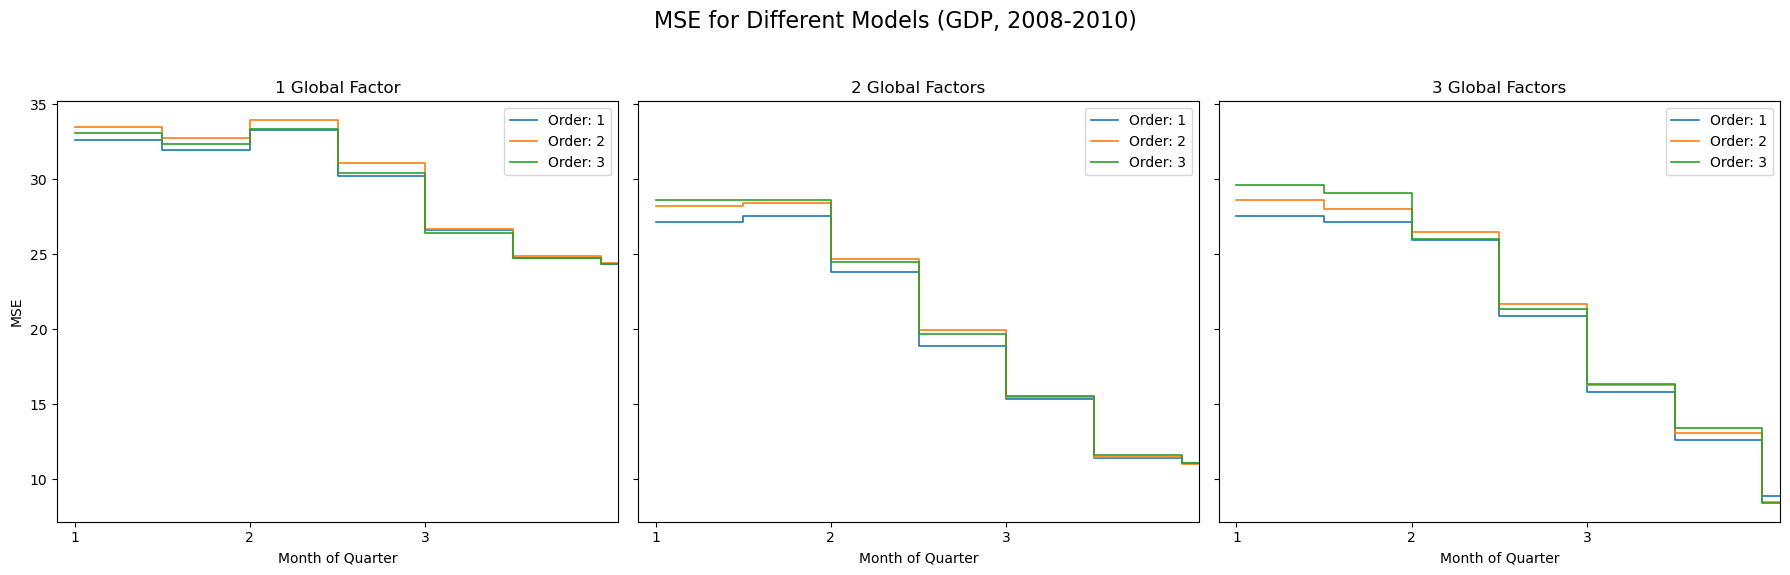

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


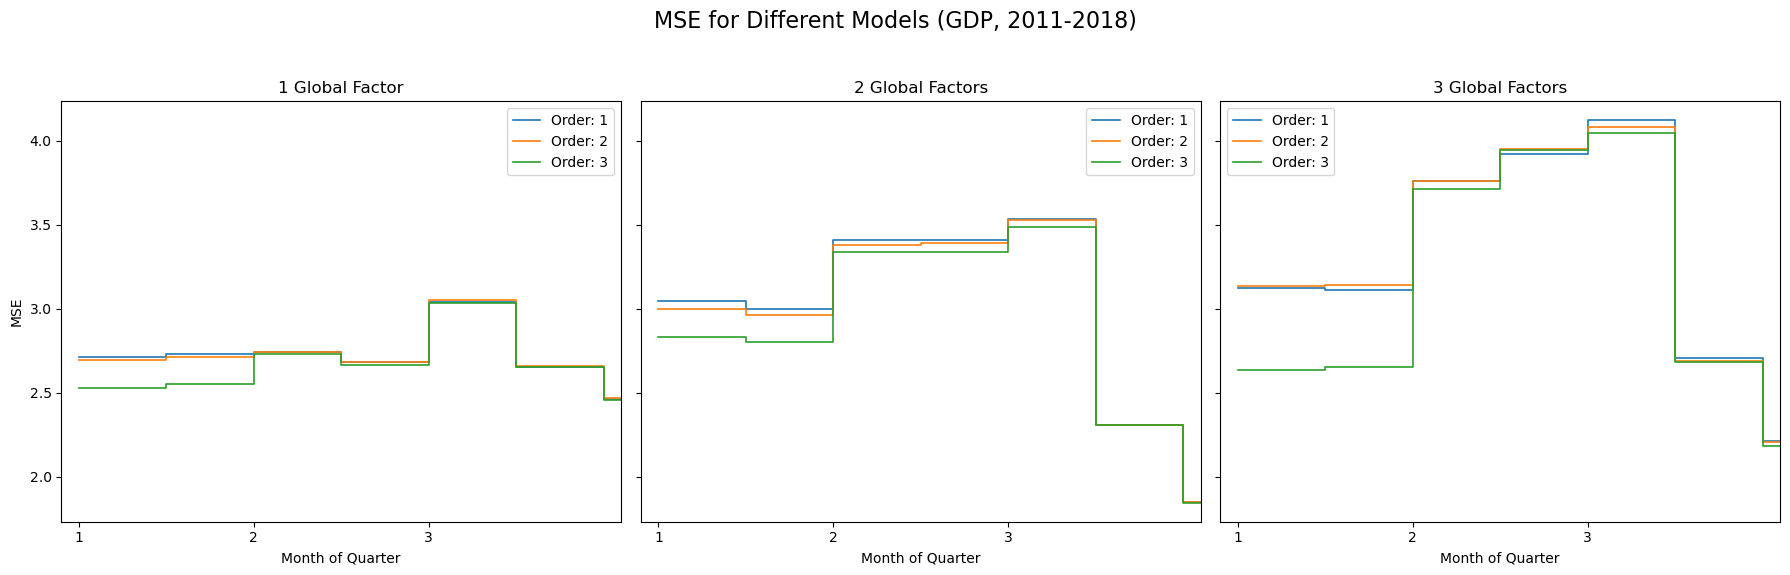

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


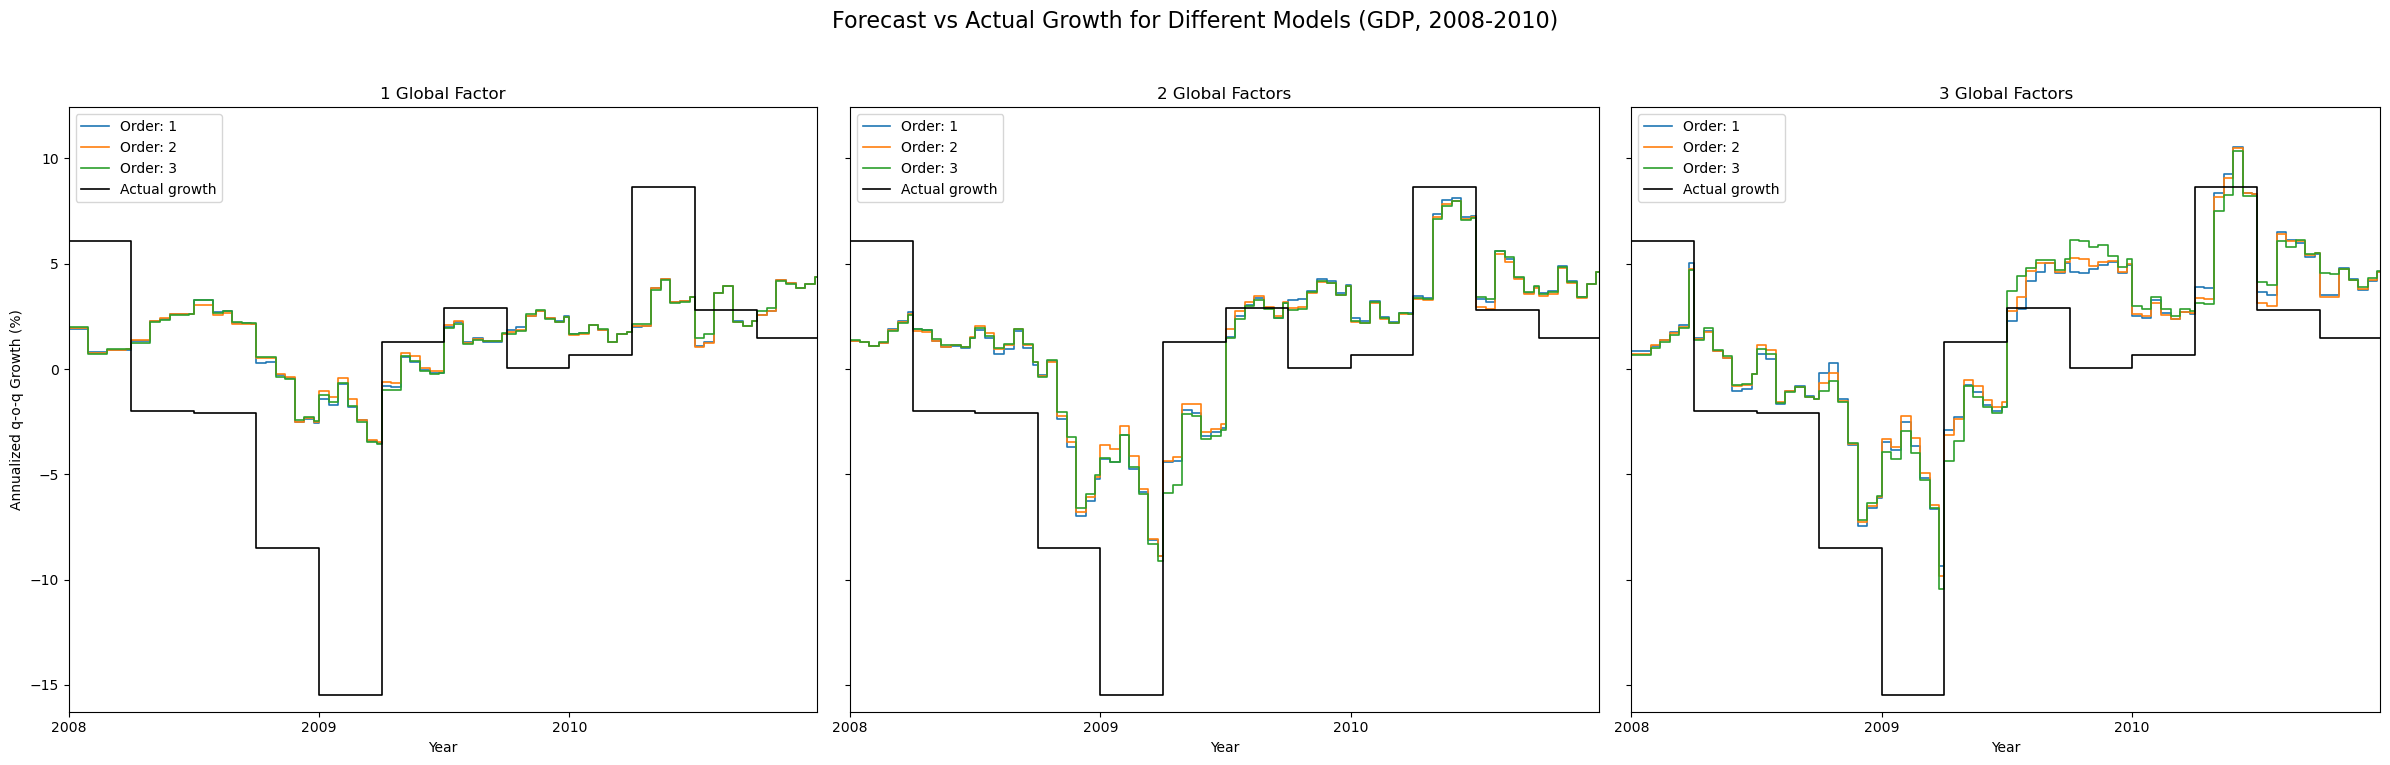

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


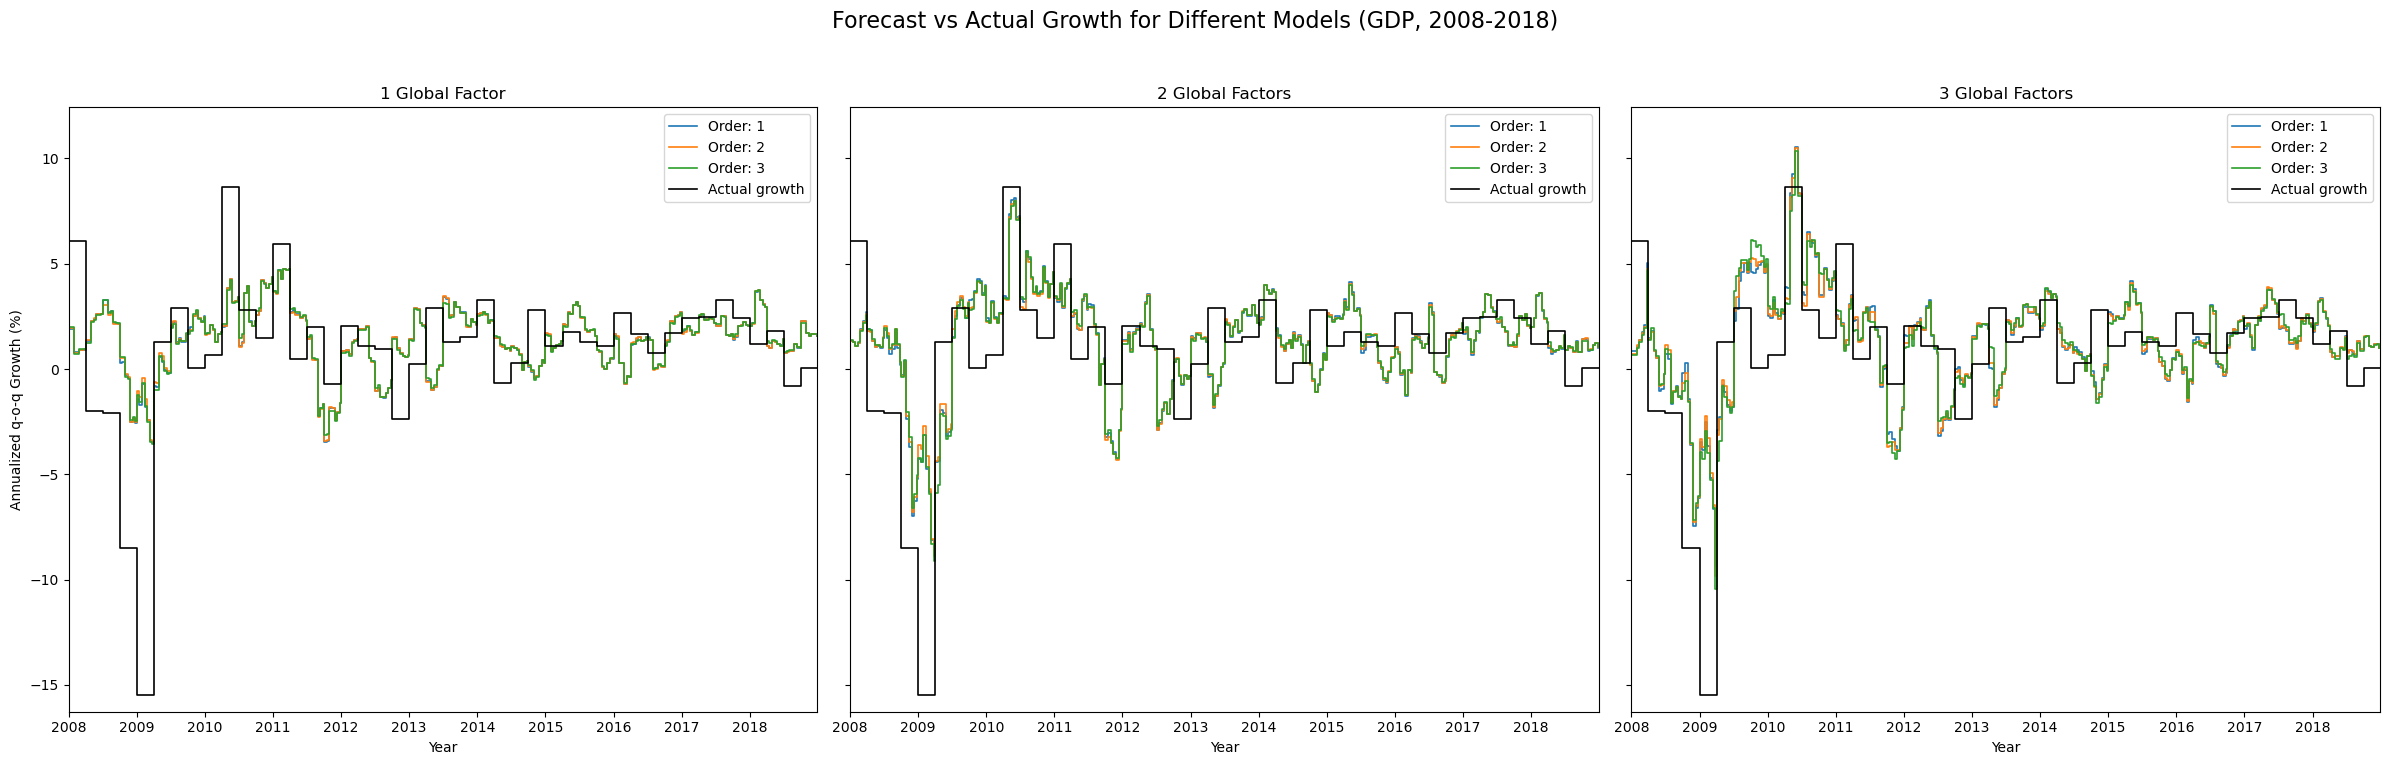

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


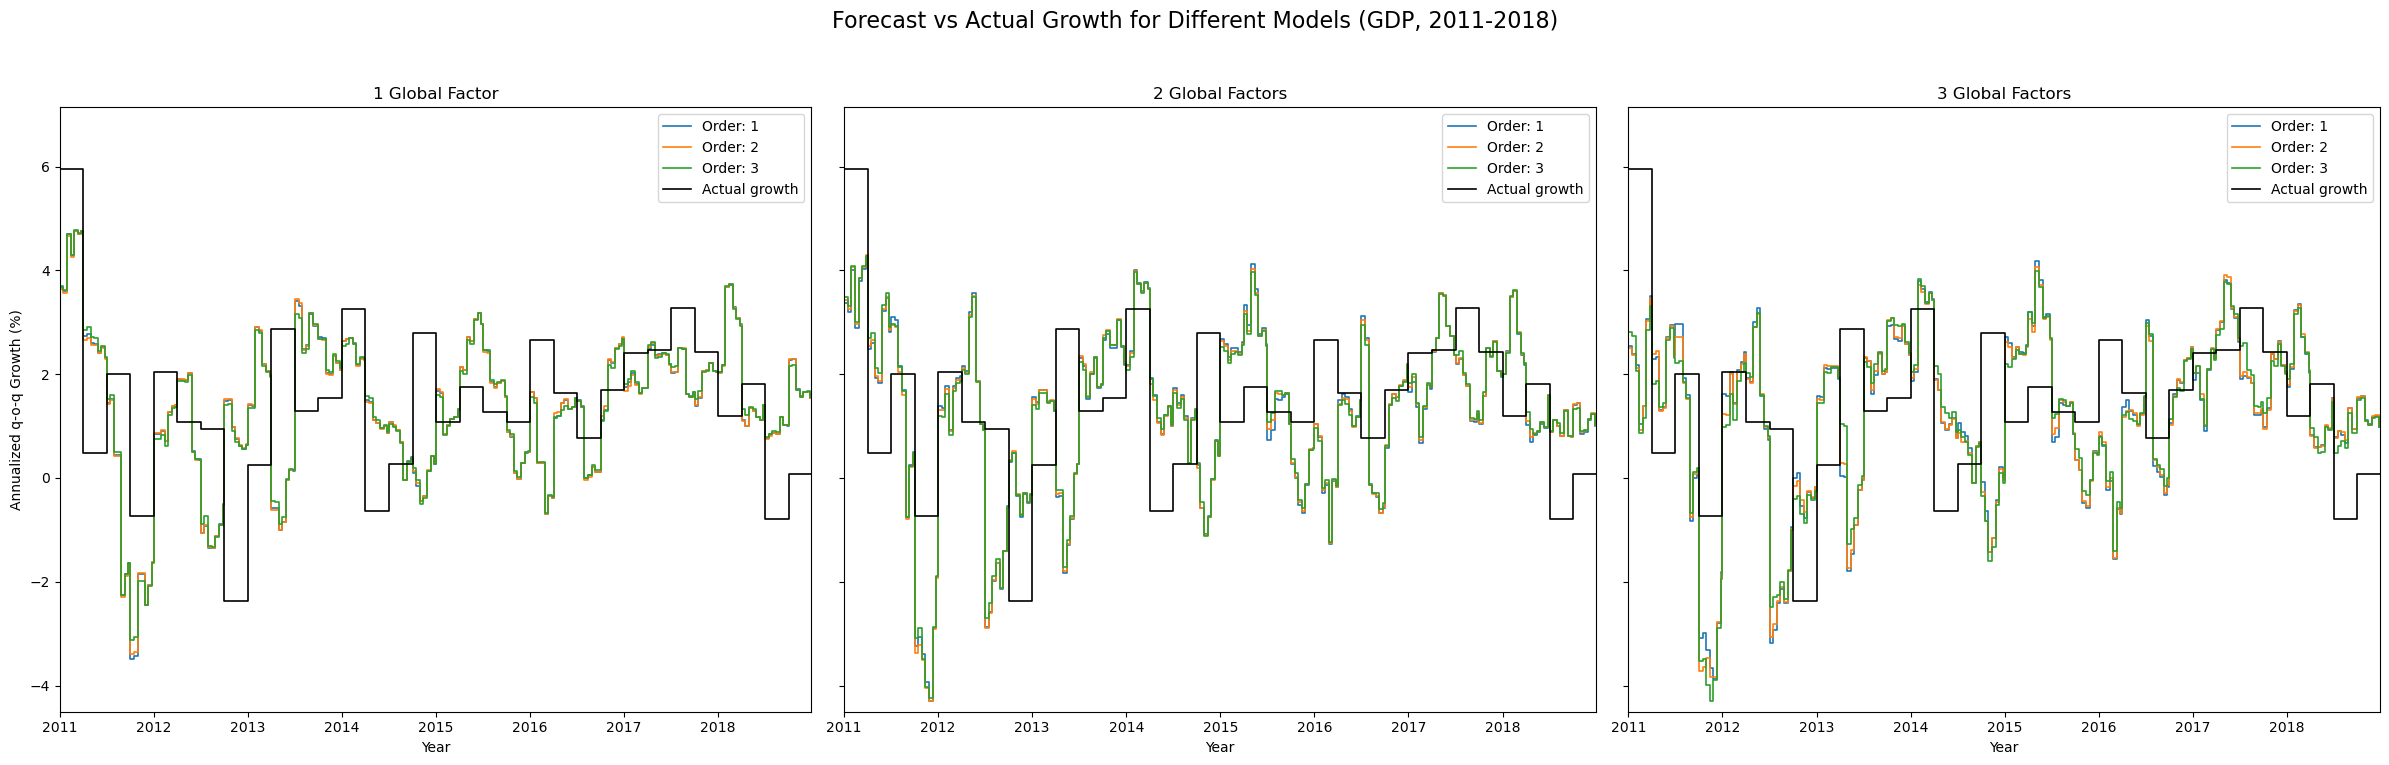

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()